In [3]:
import pandas as pd
import numpy as np

# utility
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from data_cleaning import clean_raw_data, create_dataset, get_all_results
from sklearn.utils.class_weight import compute_class_weight

#viz
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# parallel
import ray
try:
    ray.init()
except:
    print("ray already started")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, LeaveOneOut
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from augmentdatalib_source.knnor.data_augment import KNNOR
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from feature_selection import FeatureSelector
from tuning import Tuner
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

# models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# analysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None) # show all cols


SEED = 42

# reload modules in py files
%load_ext autoreload
%autoreload 2

2023-02-27 16:11:12,923	INFO worker.py:1538 -- Started a local Ray instance.


## Model Tuning

1. Take best features from feature selection 
2. Tune model using best features 


In [4]:
def get_cross_validation(X, y, test_size=.2, n_splits=3, type="stratified"):
    if type == "stratified":
        return list(StratifiedShuffleSplit(test_size=test_size, n_splits=n_splits, random_state=SEED).split(X, y))
    elif type == "leave_one_out":
        return list(LeaveOneOut().split(X, y))

In [5]:
def seaborn_conf_matrix(cm):
    plt.figure()
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

## Tune SVM

In [6]:
import sklearn
print(sklearn.__version__)

1.2.1


In [7]:
def graph_cv_results(results_df):
    plt.figure()
    # Plot loss scores using seaborn
    
    plt.xticks(rotation=90)
    sns.lineplot(data=results_df, x='params', y='mean_train_score', label='CV Training Score')
    sns.lineplot(data=results_df, x='params', y='mean_test_score', label='CV Test Score')
    plt.xlabel('')
    plt.xticks(ticks=[], labels=[])

Do we want to make a statement on an entirely new sample, this is the accuracy metrics we would expect to get?
If so, would need an inner train test loop, and an outer train test loop
Inner loop: feature selection, param tuning, 
Outer loop: winner was derived from innenr data, and here are the results on the outer data

Some papers: this algorithm is better than this other algorithm 

Do variable importance after the fact. Once I have the best model, what are the ways that people use to assess important features. 

ROC curve can be misleading with imbalanced datasets: it ignores that dataset is imbalanced. Instead might use precision recall curve. 

Need to be careful with prior probability of 60% of people goigng to NHL. migth not want balance

**Want to be able to say:** if you give me a player with this distribution, I am going to be this ___ accurate.

You should stress test your model if this was really going to be used: what if we had 40-60 distribution, other factors


Need to ask these questions: ARe we going to actually run this model, is this just for research? 

In [60]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SequentialFeatureSelector

def tune_model(model, param_dist, features, n_iter=200, balance=True, weight_classes=False, target_col=None):

    X, y = create_dataset(clean_raw_data("Brdi_db_march.xlsx"), target_col=target_col)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)

    # X_train = X_train[features]
    # X_val = X_val[features]
  
    cv = get_cross_validation(X_train, y_train, test_size=.2, n_splits=5, type="stratified")

    scaler = StandardScaler()
    selector = SequentialFeatureSelector(model, n_features_to_select="auto", direction='forward', n_jobs=-1)
    if balance:
        pipe = ImbPipeline([
                ('smote', SMOTE(random_state=SEED)),
                ('scaler', scaler),
                ('selection', selector),
                ('model', model)
            ])
    else:
        pipe = ImbPipeline([
                ('scaler', scaler),
                ('selection', selector),
                ('model', model)
            ])

    if not model.__class__.__name__  in ["MLPClassifier", "XGBClassifier", "BaggingClassifier", "AdaBoostClassifier"] and weight_classes:
        class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(zip(np.unique(y_train), class_weights))
        param_dist["model__class_weight"] = [class_weight_dict, None]

    # create random search and fit
    random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=cv, n_iter=n_iter, random_state=SEED, scoring="f1", return_train_score=True, n_jobs=-1)
    random_search.fit(X_train, y_train)

    # get features used
    features_idx = random_search.best_estimator_.named_steps['selection'].get_support()
    feature_names = X_train.columns[features_idx]

    # print search results
    print(f"Best mean test f1 during cv in Random search: {random_search.best_score_}")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Features used: {feature_names}")

    # select best estimator Random Search 
    best_estimator = random_search.best_estimator_

    # blindly apply transformation from train to val
    X_val_scaled = scaler.fit(X_train.values).transform(X_val.values)

    # predict on validation set
    y_pred = best_estimator.predict(X_val_scaled)

    # get evaluation metrics
    seaborn_conf_matrix(confusion_matrix(y_val, y_pred))
    print(f"F1 score on Validation Set: {f1_score(y_val, y_pred)}")

    # return results as DF
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    display(cv_results_df.head(5))
    cv_results_df = cv_results_df[['params', 'mean_train_score', 'mean_test_score']]
    cv_results_df['params'] = cv_results_df['params'].astype(str)
    cv_results_df = cv_results_df.sort_values(by="mean_test_score", ascending=False).head(20)
    return cv_results_df
    

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=200. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best mean test f1 during cv in Random search: 0.7714015572858731
Best parameters: {'model__kernel': 'poly', 'model__gamma': 'scale', 'model__C': 1}
Features used: Index(['age as of June 1', 'weight', 'previous concussions?',
       '# of concussions', 'bimanual score: washer', 'DR Errors: V', 'RT_HR',
       'MT_HR', 'TMT_V', 'CMT: HR', 'cvRT_V', 'stdRT_V', 'Ball Path_HR',
       'FullPath_V', 'Corrective_V', 'Corrective_HR', 'AE_HR', 'Delta_AE',
       'VE_HR', 'Delta: VE', 'AbsOnAxis_HR', 'Delta_OnAxis', 'AbsOffAxis_V'],
      dtype='object')
F1 score on Validation Set: 0.0


/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__kernel,param_model__gamma,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,32.299635,0.166907,0.016009,0.006511,rbf,0.001,0.0001,"{'model__kernel': 'rbf', 'model__gamma': 0.001, 'model__C': 0.0001}",0.75,0.75,0.75,0.75,0.75,0.75,0.0,4,0.752,0.752,0.752,0.752,0.752,0.752,0.0
1,32.228937,0.138676,0.022586,0.010927,linear,0.001,0.0001,"{'model__kernel': 'linear', 'model__gamma': 0.001, 'model__C': 0.0001}",0.75,0.75,0.75,0.75,0.75,0.75,0.0,4,0.752,0.752,0.752,0.752,0.752,0.752,0.0
2,32.493190,0.205377,0.017351,0.007142,poly,0.001,0.0001,"{'model__kernel': 'poly', 'model__gamma': 0.001, 'model__C': 0.0001}",0.75,0.75,0.75,0.75,0.75,0.75,0.0,4,0.752,0.752,0.752,0.752,0.752,0.752,0.0
3,36.258447,1.748439,0.038935,0.041338,rbf,0.0001,0.0001,"{'model__kernel': 'rbf', 'model__gamma': 0.0001, 'model__C': 0.0001}",0.75,0.75,0.75,0.75,0.75,0.75,0.0,4,0.752,0.752,0.752,0.752,0.752,0.752,0.0
4,37.400450,0.325831,0.050921,0.038823,linear,0.0001,0.0001,"{'model__kernel': 'linear', 'model__gamma': 0.0001, 'model__C': 0.0001}",0.75,0.75,0.75,0.75,0.75,0.75,0.0,4,0.752,0.752,0.752,0.752,0.752,0.752,0.0


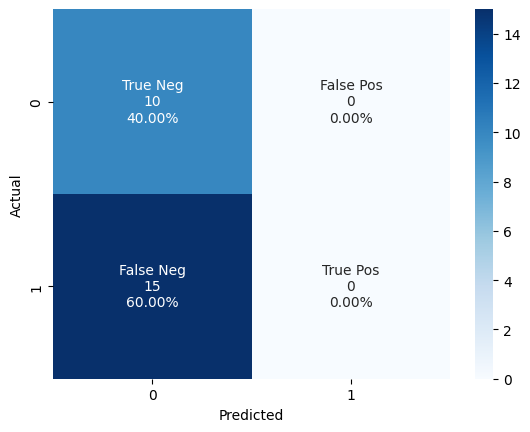

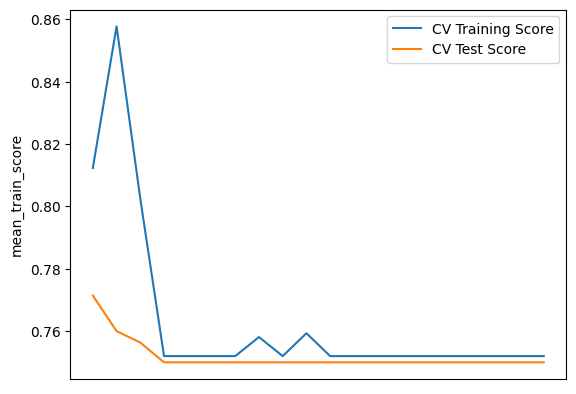

In [61]:
model = SVC(random_state=SEED)
# param_dist = {'model__C': loguniform(0.0001, 10), 'model__kernel': ['linear', 'rbf', 'poly']}

param_dist = [
# {'model__C': loguniform(0.01, 6), 'model__kernel': ['linear', 'rbf']},
#  {'model__C': [1], 'model__kernel': ['linear']},
 {'model__C': [.0001, .001, .1, 1, 3, 5], 'model__gamma': [0.001, 0.0001, "auto", "scale"], 'model__kernel': ['rbf', "linear", "poly"]},
#  {'model__C': [.001, .1, 1, 3, 5], 'model__gamma': [0.001, 0.0001, "auto", "scale"], 'model__kernel': ["poly"], "model__tol" : [1, 1e-1, 1e-2, 1e-3]},
]

svc_features = ['previous concussions?', '# of concussions', 'DR Errors: V', 'RT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'Delta_Fullpath', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis']

svc_cv_results = tune_model(model, param_dist, svc_features, balance=False, weight_classes=False, target_col="NHL")
graph_cv_results(svc_cv_results)

In [62]:
svc_cv_results

,params,mean_train_score,mean_test_score
47,"{'model__kernel': 'poly', 'model__gamma': 'scale', 'model__C': 1}",0.812317,0.771402
56,"{'model__kernel': 'poly', 'model__gamma': 'auto', 'model__C': 3}",0.857739,0.760011
44,"{'model__kernel': 'poly', 'model__gamma': 'auto', 'model__C': 1}",0.802458,0.756344
39,"{'model__kernel': 'rbf', 'model__gamma': 0.0001, 'model__C': 1}",0.752000,0.750000
27,"{'model__kernel': 'rbf', 'model__gamma': 0.0001, 'model__C': 0.1}",0.752000,0.750000
29,"{'model__kernel': 'poly', 'model__gamma': 0.0001, 'model__C': 0.1}",0.752000,0.750000
30,"{'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__C': 0.1}",0.752000,0.750000
32,"{'model__kernel': 'poly', 'model__gamma': 'auto', 'model__C': 0.1}",0.758104,0.750000
33,"{'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 0.1}",0.752000,0.750000
35,"{'model__kernel': 'poly', 'model__gamma': 'scale', 'model__C': 0.1}",0.759337,0.750000


Best training training f1: 0.6602723253757737
Best parameters: {'model__C': 4.202116526335309, 'model__class_weight': None, 'model__kernel': 'rbf'}
Test f1 score: 0.875


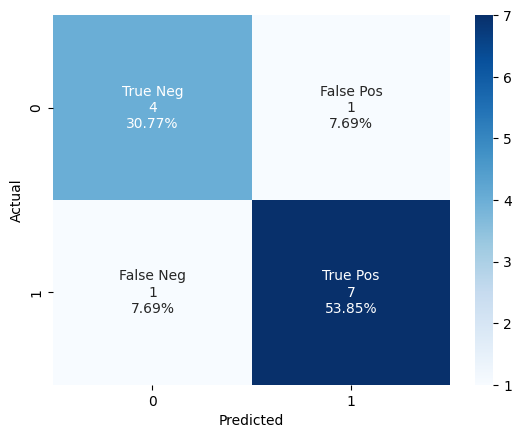

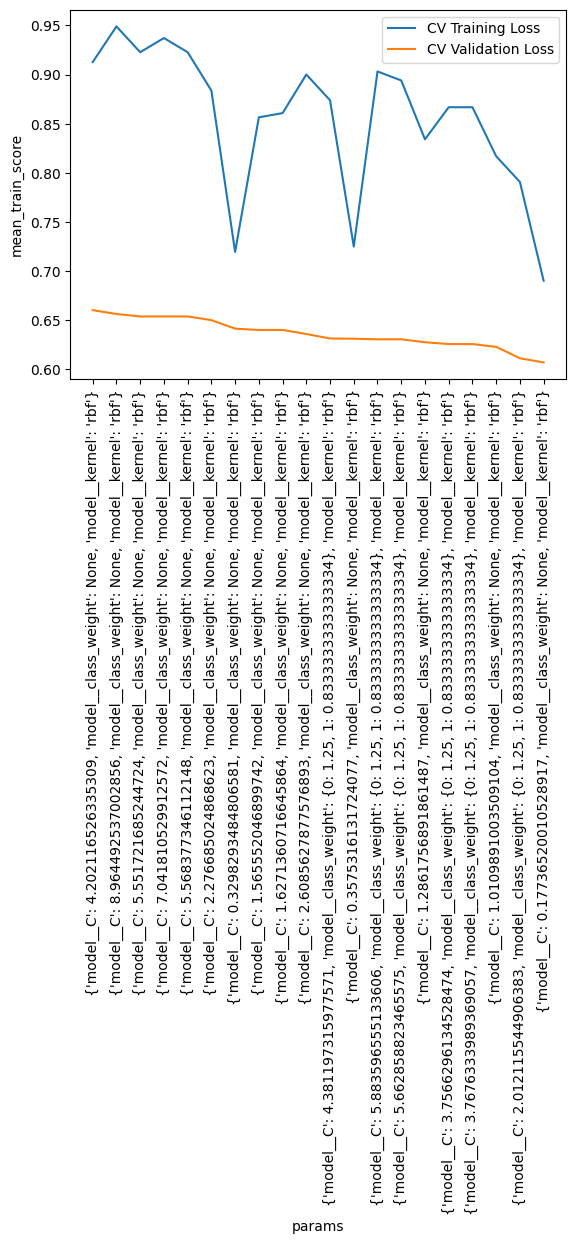

In [25]:
model = SVC(random_state=SEED)
param_dist = {'model__C': loguniform(0.0001, 10), 'model__kernel': ['linear', 'rbf', 'poly']}
svc_features = ['previous concussions?', '# of concussions', 'DR Errors: V', 'RT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'Delta_Fullpath', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis']

svc_cv_results = tune_model(model, param_dist, svc_features)
graph_cv_results(svc_cv_results)


## Decision Tree

Best training training f1: 0.7245021645021646
Best parameters: {'model__min_samples_split': 6, 'model__min_samples_leaf': 13, 'model__max_features': 'log2', 'model__max_depth': 1, 'model__criterion': 'entropy', 'model__class_weight': None}
Test f1 score: 0.8


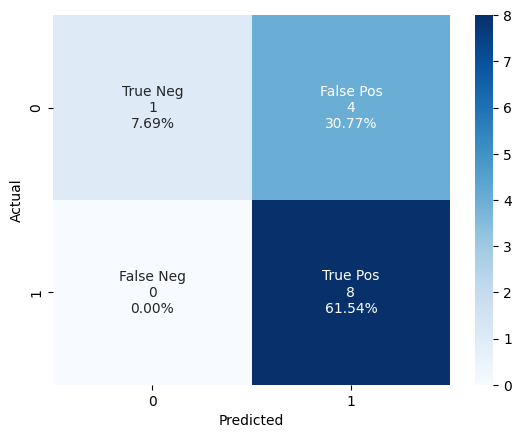

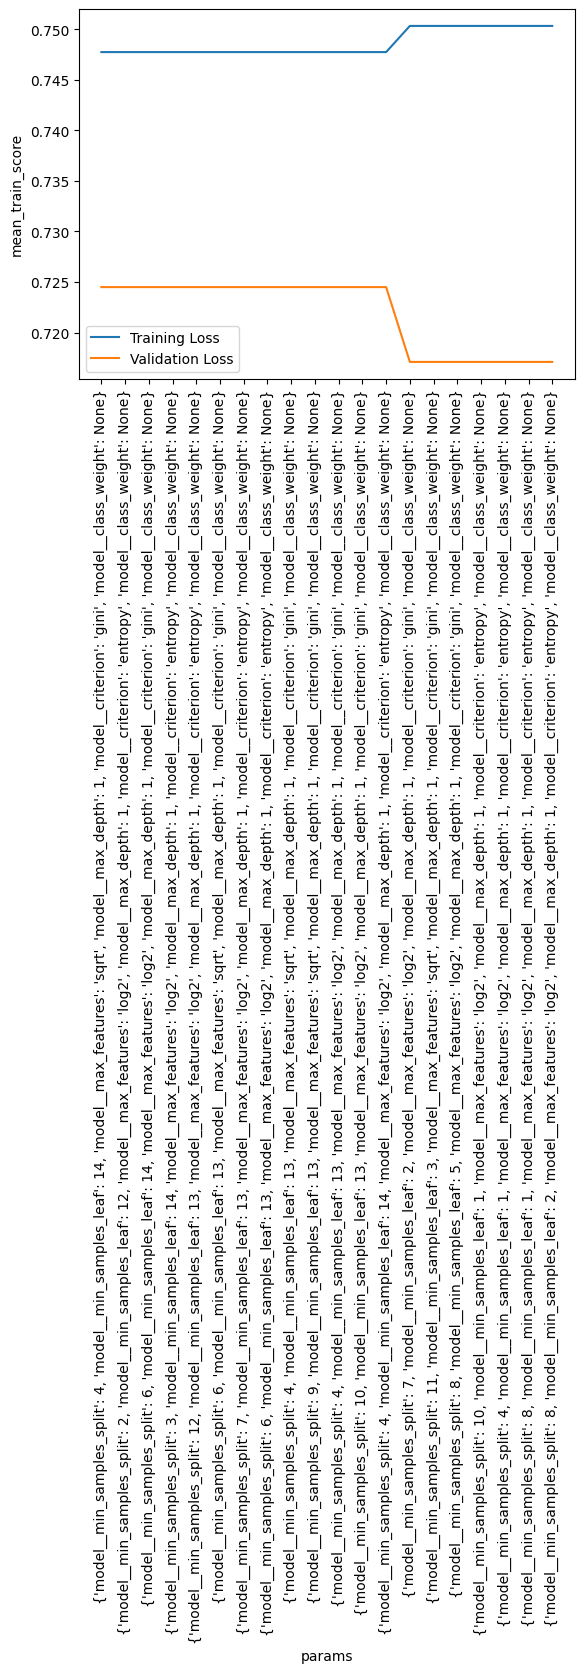

In [82]:
model = DecisionTreeClassifier(random_state=SEED)
param_dist = {
        "model__criterion" : ["gini", "entropy"],
        "model__max_depth" : range(1, 7),
        "model__min_samples_split" : range(1, 7),
        "model__min_samples_leaf" : range(1, 7),
        "model__max_features" : ["sqrt", "log2", None],
        "model__class_weight" : [None, "balanced"]
    }

dt_features = ['age as of June 1', 'previous concussions?', '# of concussions', 'Bimanual Score: Button', 'DR Errors: V', 'DR Errors: HR', 'MT_HR', 'FullPath_HR', 'Delta_PV', 'AE_HR', 'Delta: VE', 'AbsOnAxis_HR', 'Delta_OnAxis']

dt_cv_results = tune_model(model, param_dist, dt_features, n_iter=200, balance=False)
graph_cv_results(dt_cv_results)

## Random Forest

**Note** This cell as it is setup now takes around 50 minutes

Best parameters: {'model__n_estimators': 50, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 9, 'model__class_weight': None}
Best f1: 0.6027252747252748
0.7058823529411765


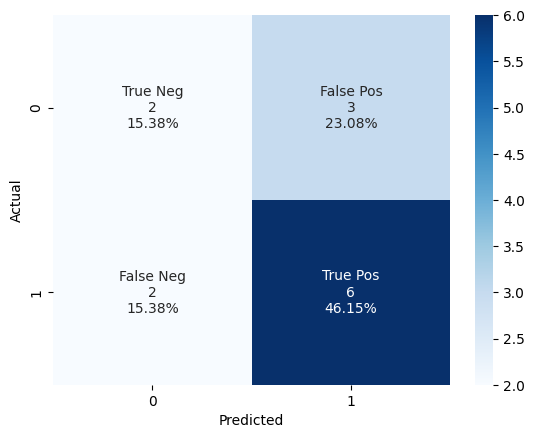

In [20]:
model = RandomForestClassifier(random_state=SEED)
param_dist = {
                'model__n_estimators': [50, 100, 200, 300],
                "model__max_depth" : range(1, 15),
                "model__min_samples_split" : range(1, 15),
                "model__min_samples_leaf" : range(1, 15),
                'model__max_features': ['sqrt', 'log2']}

rf_features = ['height', 'previous concussions?', '# of concussions', 'DR Errors: HR', 'Delta_RT', 'CMT: V', 'CMT: HR', 'cvRT_V', 'stdRT_V', 'Ball Path_V', 'FullPath_V', 'FullPath_HR', 'Corrective_V', 'Corrective_HR', 'AbsOnAxis_V', 'Delta_OffAxis']

tune_model(model, param_dist, rf_features, n_iter=2000)

## MLP

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

Best training training f1: 0.7171072065189713
Best parameters: {'model__activation': 'relu', 'model__alpha': 2.6317949285715792e-05, 'model__hidden_layer_sizes': (100,), 'model__learning_rate_init': 7.689033715836228e-05, 'model__solver': 'sgd'}
Test f1 score: 0.761904761904762


,params,mean_train_score,mean_test_score
67,"{'model__activation': 'relu', 'model__alpha': 2.6317949285715792e-05, 'model__hidden_layer_sizes': (100,), 'model__learning_rate_init': 7.689033715836228e-05, 'model__solver': 'sgd'}",0.744932,0.717107
1,"{'model__activation': 'relu', 'model__alpha': 2.938027938703535e-05, 'model__hidden_layer_sizes': (100,), 'model__learning_rate_init': 1.9949166150633933e-05, 'model__solver': 'adam'}",0.744549,0.692651
24,"{'model__activation': 'tanh', 'model__alpha': 5.1045182309028066e-05, 'model__hidden_layer_sizes': (50, 100, 50), 'model__learning_rate_init': 0.0003029610442821248, 'model__solver': 'lbfgs'}",1.000000,0.691876
47,"{'model__activation': 'tanh', 'model__alpha': 5.9405257557019275e-05, 'model__hidden_layer_sizes': (50, 100, 50), 'model__learning_rate_init': 0.008841074088520707, 'model__solver': 'lbfgs'}",1.000000,0.691876
91,"{'model__activation': 'tanh', 'model__alpha': 0.00031850749155146543, 'model__hidden_layer_sizes': (50, 50, 50), 'model__learning_rate_init': 0.0011269153853645157, 'model__solver': 'adam'}",1.000000,0.691005
80,"{'model__activation': 'relu', 'model__alpha': 5.656940124966406e-05, 'model__hidden_layer_sizes': (50, 100, 50), 'model__learning_rate_init': 0.007725831714587855, 'model__solver': 'adam'}",1.000000,0.688960
41,"{'model__activation': 'tanh', 'model__alpha': 0.008918040138190564, 'model__hidden_layer_sizes': (50, 100, 50), 'model__learning_rate_init': 0.00040487788181534096, 'model__solver': 'lbfgs'}",1.000000,0.687839
96,"{'model__activation': 'tanh', 'model__alpha': 1.3088485521916078e-05, 'model__hidden_layer_sizes': (50, 100, 50), 'model__learning_rate_init': 0.0011194902621864977, 'model__solver': 'lbfgs'}",1.000000,0.686359
93,"{'model__activation': 'relu', 'model__alpha': 0.0008508728286362319, 'model__hidden_layer_sizes': (50, 50, 50), 'model__learning_rate_init': 0.0027140167909720857, 'model__solver': 'adam'}",1.000000,0.686043
20,"{'model__activation': 'relu', 'model__alpha': 0.0008979064194712972, 'model__hidden_layer_sizes': (100,), 'model__learning_rate_init': 0.0035490795460959693, 'model__solver': 'sgd'}",0.883622,0.680763


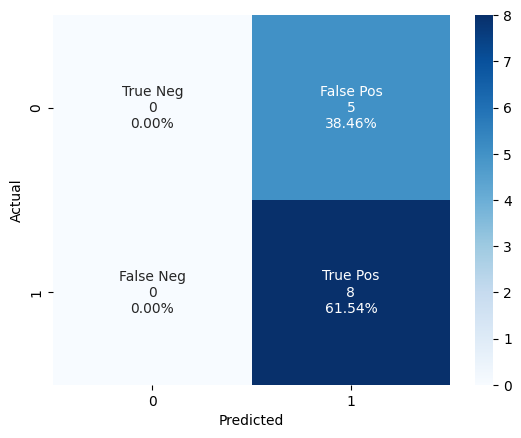

In [92]:
model = MLPClassifier(random_state=SEED, max_iter=1000)
param_dist = {
    'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'model__alpha': loguniform(1e-5, 1e-2),
    'model__learning_rate_init': loguniform(1e-5, 1e-2),
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['lbfgs', 'sgd', 'adam']
}

mlp_features = ['age as of June 1', 'height', 'weight', 'DR Errors: V', 'RT_V', 'Delta_MT', 'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AbsOnAxis_HR']
tune_model(model, param_dist, mlp_features, n_iter=100)

------
## Logistic Regression

Note: have to be careful with C (regularization param)<br>
Setting it too small will result in good training accuracy but the model will overfit and perform very badly for the test data

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1610 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/pytho

Best training training f1: 0.7428571428571429
Best parameters: {'model__C': 0.059078142825305296, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'saga'}
Test f1 score: 0.823529411764706


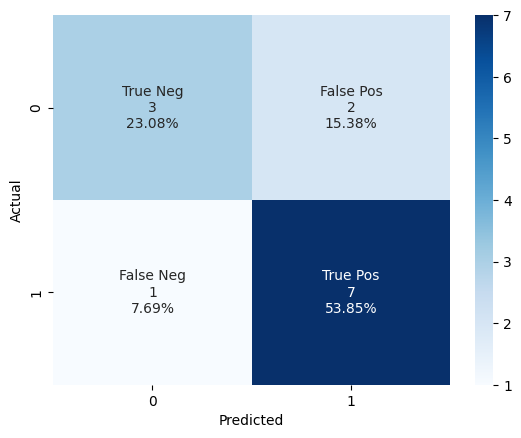

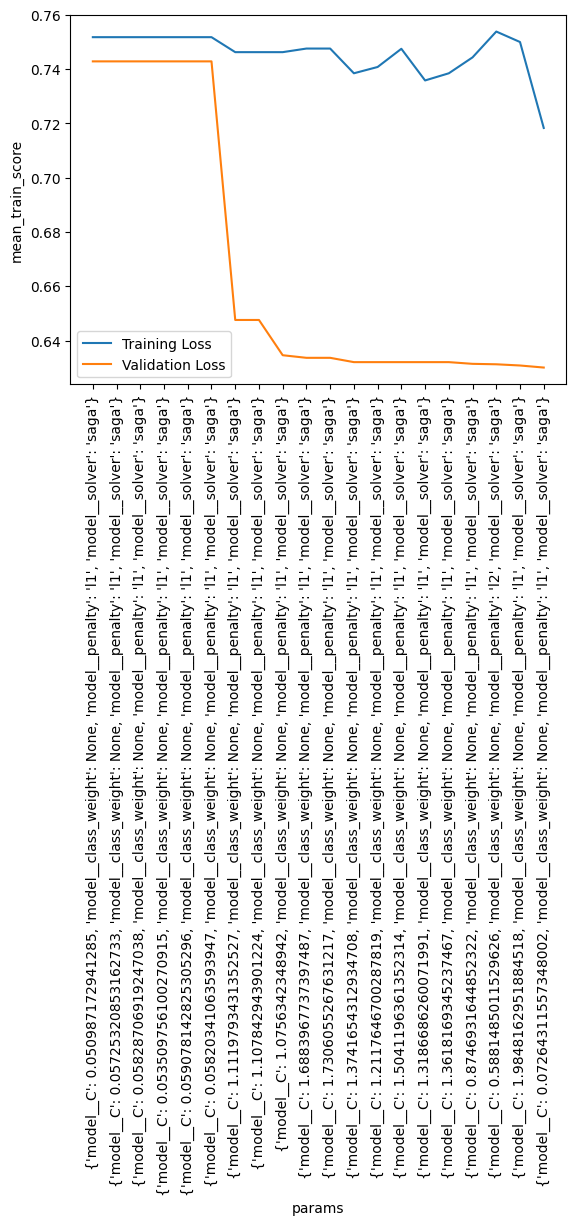

In [83]:
model = LogisticRegression(random_state=SEED, max_iter=1000)
param_dist = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': loguniform(.05, 2),
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': [None, 'balanced']
}

lr_features = ['# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'DR Errors: V', 'DR Errors: HR', 'RT_HR', 'Delta_MT', 'TMT_HR', 'CMT: HR', 'Ball Path_V', 'Ball Path_HR', 'FullPath_HR', 'PeakV_V', 'AE_V', 'VE_V', 'AbsOnAxis_V', 'Delta_OffAxis']

lr_cv_results = tune_model(model, param_dist, lr_features, n_iter=1000)
graph_cv_results(lr_cv_results)


------
## XGB

**Note** This cell takes about 13 minutes to run 

[15:40:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[15:40:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[15:40:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[15:40:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[15:40:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[15:40:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/

,params,mean_train_score,mean_test_score
932,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 0.5, 'model__class_weight': {0: 1.25, 1: 0.8333333333333334}}",0.948052,0.665276
145,"{'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.8, 'model__class_weight': None}",1.000000,0.661336
630,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.5, 'model__class_weight': {0: 1.25, 1: 0.8333333333333334}}",0.942453,0.660609
660,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.5, 'model__class_weight': None}",0.942453,0.660609
496,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0.2, 'model__colsample_bytree': 0.5, 'model__class_weight': None}",0.935233,0.660381
577,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8, 'model__class_weight': None}",0.939867,0.657479
87,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8, 'model__class_weight': {0: 1.25, 1: 0.8333333333333334}}",0.939867,0.657479
840,"{'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 0.5, 'model__class_weight': None}",1.000000,0.656900
394,"{'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.8, 'model__class_weight': {0: 1.25, 1: 0.8333333333333334}}",1.000000,0.656574
911,"{'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0.2, 'model__colsample_bytree': 0.8, 'model__class_weight': None}",0.965815,0.656381


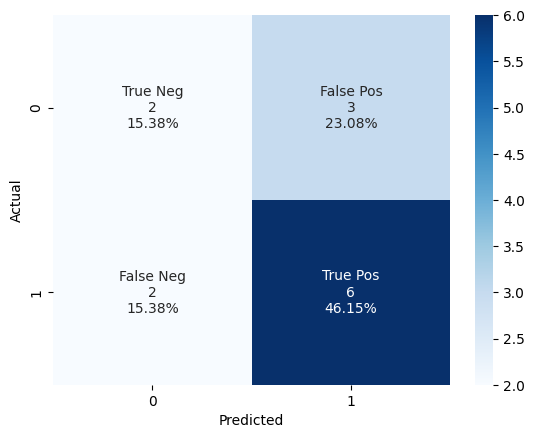

In [87]:
model = XGBClassifier(random_state=SEED)

param_dist = {
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [50, 100, 200],
    'model__gamma': [0, 0.1, 0.2],
    'model__subsample': [0.5, 0.8, 1.0],
    'model__colsample_bytree': [0.5, 0.8, 1.0]
}

xgb_features = ['age as of June 1', 'Bimanual Score: Button', 'DR Errors: V', 'DR Errors: HR', 'CMT: V', 'cvRT_HR', 'stdRT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'FullPath_HR', 'Corrective_V', 'VE_V', 'Delta: VE', 'AbsOnAxis_V', 'AbsOnAxis_HR']

tune_model(model, param_dist, xgb_features, n_iter=1000)

----

## Bagged / Boosted SVC

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: Futu

Best training training f1: 0.6682046229632437
Best parameters: {'model__base_estimator__C': 0.40596116104843044, 'model__base_estimator__kernel': 'rbf', 'model__n_estimators': 10}
Test f1 score: 0.875


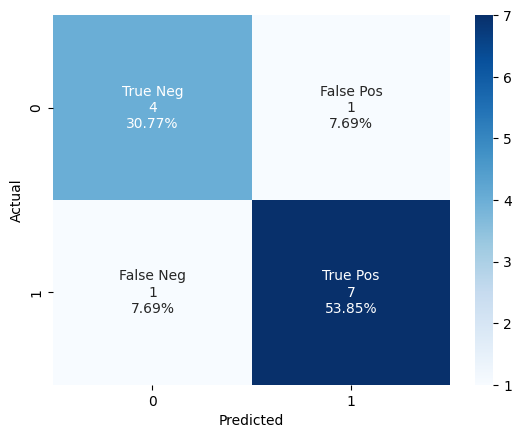

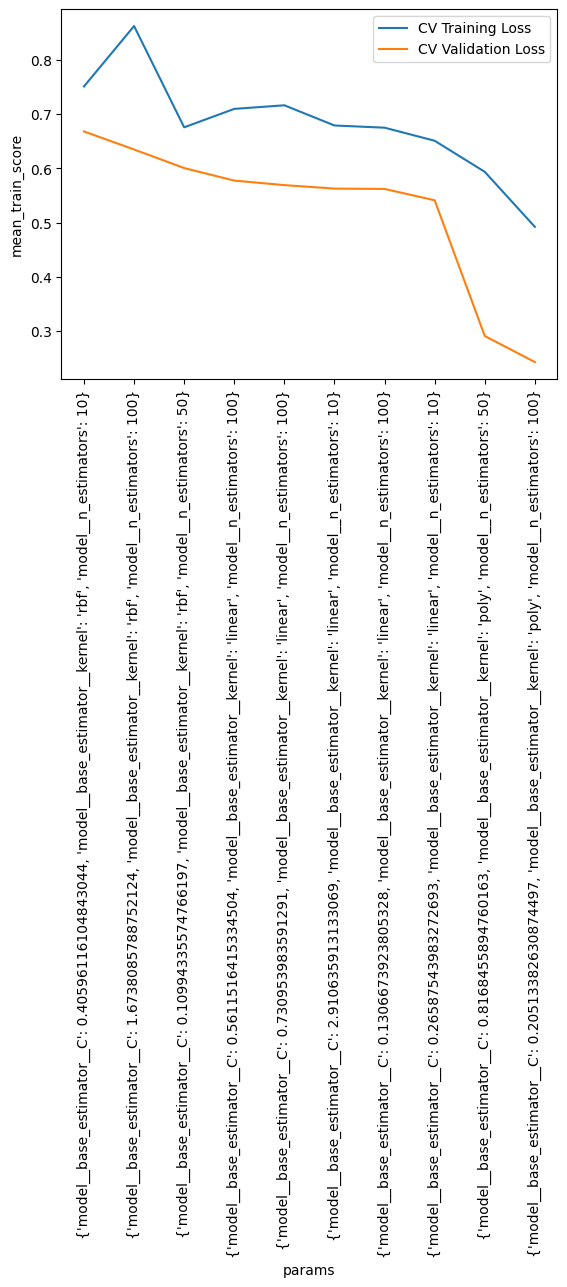

In [102]:
model = BaggingClassifier(base_estimator=SVC(random_state=SEED), random_state=SEED)
param_dist = {
        'model__base_estimator__C': loguniform(0.1, 10),
        'model__base_estimator__kernel': ['linear', 'rbf', 'poly'],
        'model__n_estimators': [10, 50, 100]
    }

svc_features = ['previous concussions?', '# of concussions', 'DR Errors: V', 'RT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'Delta_Fullpath', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis']

bagged_svc_cv_results = tune_model(model, param_dist, svc_features, n_iter=10)
# graph_cv_results(bagged_svc_cv_results)

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: Futu

Best training training f1: 0.6689402551471517
Best parameters: {'model__base_estimator__C': 0.40596116104843044, 'model__base_estimator__kernel': 'rbf', 'model__n_estimators': 10}
Test f1 score: 0.7999999999999999


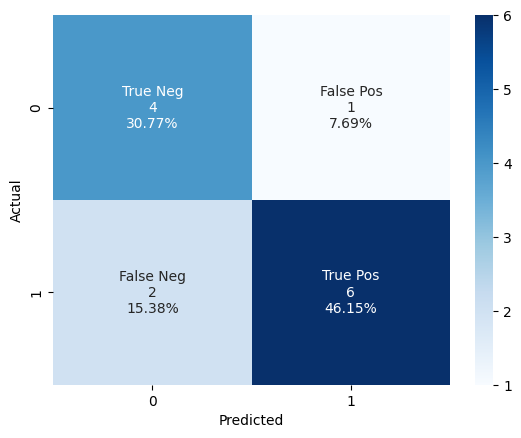

In [107]:
model = AdaBoostClassifier(base_estimator=SVC(random_state=SEED), random_state=SEED, algorithm='SAMME')
param_dist = {'model__base_estimator__C': loguniform(0.1, 10), 'model__base_estimator__kernel': ['linear', 'rbf', 'poly'], 'model__n_estimators': [10, 50, 100]}
svc_features = ['previous concussions?', '# of concussions', 'DR Errors: V', 'RT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'Delta_Fullpath', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis']

bagged_svc_cv_results = tune_model(model, param_dist, svc_features, n_iter=10)
# graph_cv_results(bagged_svc_cv_results)

------
## Bagged and Boosted Decision Tree

Best training training f1: 0.6631428571428571
Best parameters: {'model__n_estimators': 10, 'model__estimator__min_samples_split': 7, 'model__estimator__min_samples_leaf': 11, 'model__estimator__max_features': 'sqrt', 'model__estimator__max_depth': 5, 'model__estimator__criterion': 'gini', 'model__estimator__class_weight': 'balanced'}
Test f1 score: 0.875


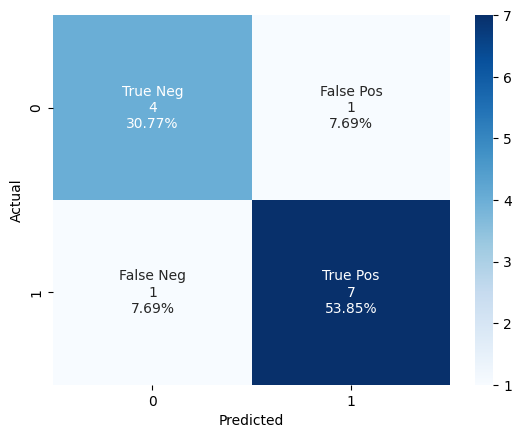

In [118]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED)
param_dist = {
        "model__n_estimators" : [10, 50, 100],
        "model__estimator__criterion" : ["gini", "entropy"],
        "model__estimator__max_depth" : range(1, 15),
        "model__estimator__min_samples_split" : range(1, 15),
        "model__estimator__min_samples_leaf" : range(1, 15),
        "model__estimator__max_features" : ["sqrt", "log2", None],
        "model__estimator__class_weight" : [None, "balanced"]
    }

dt_features = ['previous concussions?', '# of concussions', 'DR Errors: V', 'RT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'Delta_Fullpath', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis']

bagged_dt_cv_results = tune_model(model, param_dist, dt_features, n_iter=50)


Best training training f1: 0.6637910906298004
Best parameters: {'model__n_estimators': 50, 'model__estimator__min_samples_split': 6, 'model__estimator__min_samples_leaf': 2, 'model__estimator__max_features': 'sqrt', 'model__estimator__max_depth': 2, 'model__estimator__criterion': 'gini', 'model__estimator__class_weight': 'balanced'}
Test f1 score: 0.6666666666666666


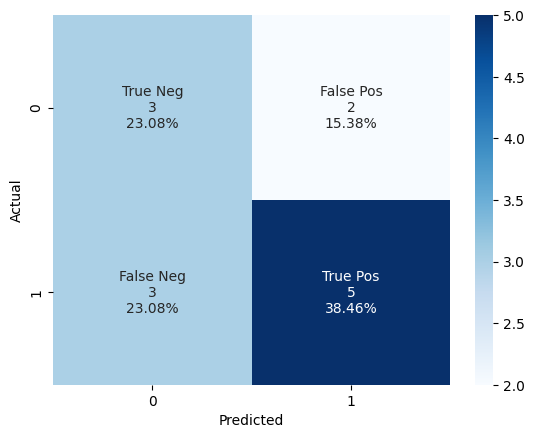

In [119]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED)
param_dist = {
        "model__n_estimators" : [10, 50, 100],
        "model__estimator__criterion" : ["gini", "entropy"],
        "model__estimator__max_depth" : range(1, 15),
        "model__estimator__min_samples_split" : range(1, 15),
        "model__estimator__min_samples_leaf" : range(1, 15),
        "model__estimator__max_features" : ["sqrt", "log2", None],
        "model__estimator__class_weight" : [None, "balanced"]
    }

dt_features = ['previous concussions?', '# of concussions', 'DR Errors: V', 'RT_HR', 'Ball Path_HR', 'Delta_BallPath', 'FullPath_V', 'Delta_Fullpath', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_V', 'AbsOnAxis_HR', 'Delta_OnAxis']

bagged_dt_cv_results = tune_model(model, param_dist, dt_features, n_iter=100)

-------
## Bagged and Boosted Random Forest

## Note: This cell takes about 100 minutes to run

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: Futu

Best training training f1: 0.5200049547875636
Best parameters: {'model__n_estimators': 10, 'model__base_estimator__n_estimators': 200, 'model__base_estimator__min_samples_split': 9, 'model__base_estimator__min_samples_leaf': 3, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 13}
Test f1 score: 0.5882352941176471


,params,mean_train_score,mean_test_score
23,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 200, 'model__base_estimator__min_samples_split': 9, 'model__base_estimator__min_samples_leaf': 3, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 13}",0.895807,0.520005
0,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 100, 'model__base_estimator__min_samples_split': 1, 'model__base_estimator__min_samples_leaf': 11, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 4}",0.750082,0.514095
12,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 100, 'model__base_estimator__min_samples_split': 11, 'model__base_estimator__min_samples_leaf': 11, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 14}",0.750082,0.514095
74,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 100, 'model__base_estimator__min_samples_split': 1, 'model__base_estimator__min_samples_leaf': 4, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 12}",0.901561,0.512466
82,"{'model__n_estimators': 50, 'model__base_estimator__n_estimators': 300, 'model__base_estimator__min_samples_split': 1, 'model__base_estimator__min_samples_leaf': 7, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 6}",0.854152,0.512202
63,"{'model__n_estimators': 50, 'model__base_estimator__n_estimators': 300, 'model__base_estimator__min_samples_split': 12, 'model__base_estimator__min_samples_leaf': 7, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 11}",0.854152,0.512202
53,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 100, 'model__base_estimator__min_samples_split': 11, 'model__base_estimator__min_samples_leaf': 9, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 9}",0.779667,0.511098
42,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 300, 'model__base_estimator__min_samples_split': 9, 'model__base_estimator__min_samples_leaf': 11, 'model__base_estimator__max_features': 'log2', 'model__base_estimator__max_depth': 8}",0.759140,0.510952
54,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 100, 'model__base_estimator__min_samples_split': 1, 'model__base_estimator__min_samples_leaf': 10, 'model__base_estimator__max_features': 'log2', 'model__base_estimator__max_depth': 2}",0.765266,0.510403
33,"{'model__n_estimators': 10, 'model__base_estimator__n_estimators': 100, 'model__base_estimator__min_samples_split': 1, 'model__base_estimator__min_samples_leaf': 10, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_depth': 11}",0.769178,0.510403


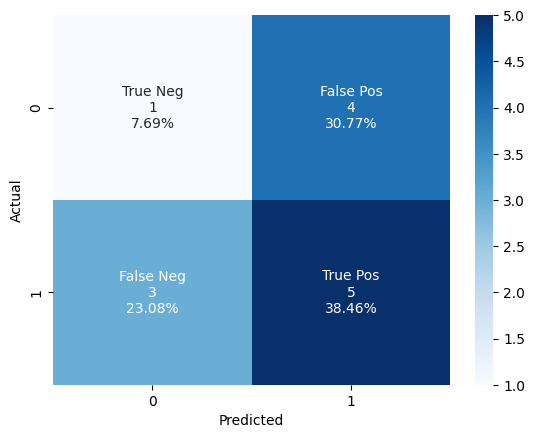

In [117]:
model = BaggingClassifier(estimator=RandomForestClassifier(random_state=SEED), random_state=SEED)
param_dist = {
                "model__n_estimators" : [10, 50, 100],
                'model__estimator__n_estimators': [50, 100, 200, 300],
                "model__estimator__max_depth" : range(1, 15),
                "model__estimator__min_samples_split" : range(1, 15),
                "model__estimator__min_samples_leaf" : range(1, 15),
                'model__estimator__max_features': ['sqrt', 'log2']
            }

rf_features = ['height', 'previous concussions?', '# of concussions', 'DR Errors: HR', 'Delta_RT', 'CMT: V', 'CMT: HR', 'cvRT_V', 'stdRT_V', 'Ball Path_V', 'FullPath_V', 'FullPath_HR', 'Corrective_V', 'Corrective_HR', 'AbsOnAxis_V', 'Delta_OffAxis']

bagged_rf_cv_results = tune_model(model, param_dist, rf_features, n_iter=100)

---------
## Bagged and Boosted MLP

**Note** You can't use mlp classifier + ADAboost as MLP classifier does not support sample_weights which Adaboost uses

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptr

Best training training f1: 0.7428571428571429
Best parameters: {'model__estimator__activation': 'relu', 'model__estimator__alpha': 0.0007848911918111945, 'model__estimator__hidden_layer_sizes': (10, 10, 10), 'model__estimator__learning_rate_init': 1.3783237455007182e-05, 'model__estimator__solver': 'adam', 'model__n_estimators': 100}
Test f1 score: 0.761904761904762


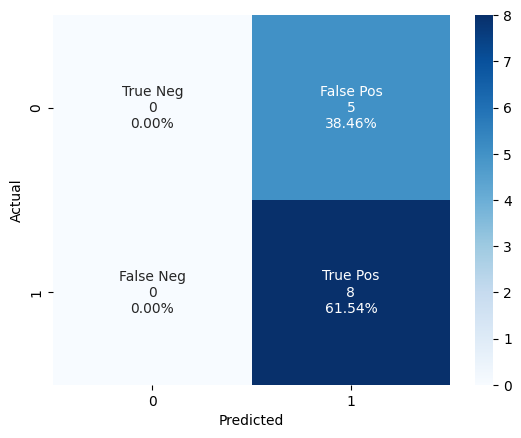

In [13]:
model = BaggingClassifier(estimator=MLPClassifier(random_state=SEED, max_iter=1000), random_state=SEED)
param_dist = {
    'model__n_estimators': [10, 50, 100],
    'model__estimator__hidden_layer_sizes': [(10,10,10), (5,10,5), (10,)],
    'model__estimator__alpha': loguniform(1e-5, .9),
    'model__estimator__learning_rate_init': loguniform(1e-5, 1e-2),
    'model__estimator__activation': ['relu', 'tanh'],
    'model__estimator__solver': ['lbfgs', 'sgd', 'adam']
}

mlp_features = ['age as of June 1', 'height', 'weight', 'DR Errors: V', 'RT_V', 'Delta_MT', 'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AbsOnAxis_HR']
bagged_mlp_cv_results = tune_model(model, param_dist, mlp_features, n_iter=10)

------
## Bagged and Boosted Logistic Regression

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

Best training training f1: 0.6105256837670631
Best parameters: {'model__estimator__C': 0.550529128090978, 'model__estimator__class_weight': None, 'model__estimator__penalty': 'l1', 'model__estimator__solver': 'liblinear', 'model__n_estimators': 50}
Test f1 score: 0.6666666666666665


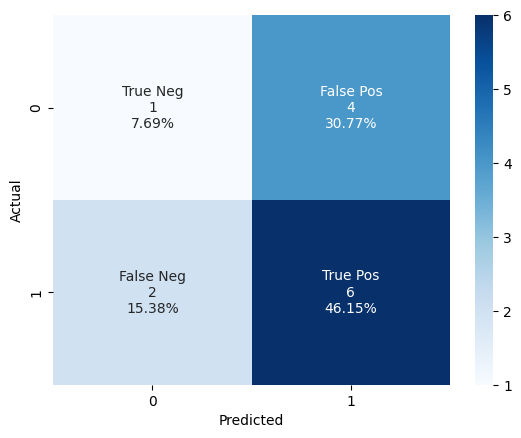

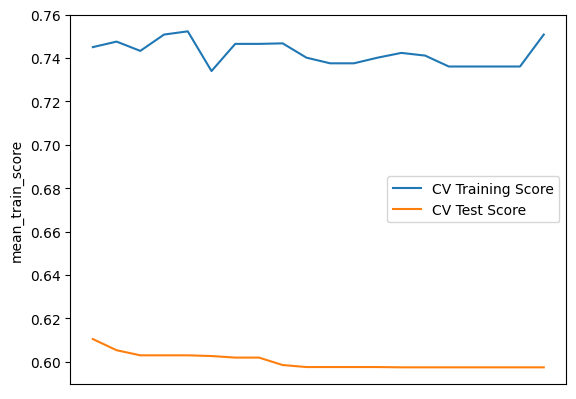

In [10]:
model = BaggingClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)

param_dist = {
    'model__n_estimators': [10, 50, 100],
    'model__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'model__estimator__C': loguniform(.05, 2),
    'model__estimator__solver': ['liblinear', 'saga'],
    'model__estimator__class_weight': [None, 'balanced']
}

lr_features = ['# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'DR Errors: V', 'DR Errors: HR', 'RT_HR', 'Delta_MT', 'TMT_HR', 'CMT: HR', 'Ball Path_V', 'Ball Path_HR', 'FullPath_HR', 'PeakV_V', 'AE_V', 'VE_V', 'AbsOnAxis_V', 'Delta_OffAxis']

bagged_lr_cv_results = tune_model(model, param_dist, lr_features, n_iter=1000)
graph_cv_results(bagged_lr_cv_results)

/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1590 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
805 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/python3.9/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/MichaelMoschitto/Desktop/Thesis/.venv/lib/pytho

Best training training f1: 0.6216289704610061
Best parameters: {'model__estimator__C': 0.19520879757405313, 'model__estimator__class_weight': 'balanced', 'model__estimator__penalty': 'l2', 'model__estimator__solver': 'liblinear', 'model__n_estimators': 100}
Test f1 score: 0.5882352941176471


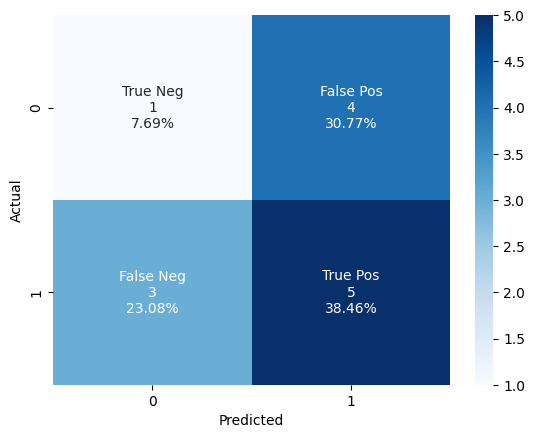

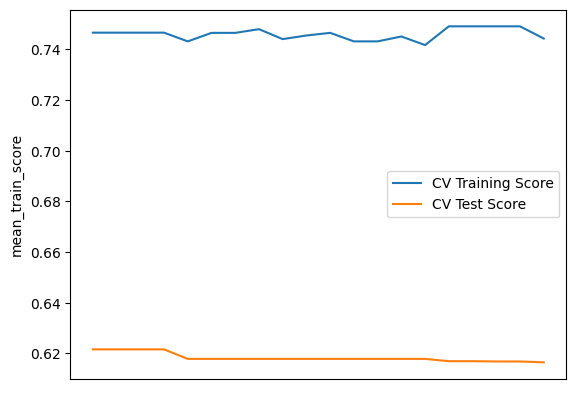

In [11]:
model = AdaBoostClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)

param_dist = {
    'model__n_estimators': [10, 50, 100],
    'model__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'model__estimator__C': loguniform(.05, 2),
    'model__estimator__solver': ['liblinear', 'saga'],
    'model__estimator__class_weight': [None, 'balanced']
}

lr_features = ['# of concussions', 'bimanual score: washer', 'Bimanual Score: Button', 'DR Errors: V', 'DR Errors: HR', 'RT_HR', 'Delta_MT', 'TMT_HR', 'CMT: HR', 'Ball Path_V', 'Ball Path_HR', 'FullPath_HR', 'PeakV_V', 'AE_V', 'VE_V', 'AbsOnAxis_V', 'Delta_OffAxis']

boosted_lr_cv_results = tune_model(model, param_dist, lr_features, n_iter=1000)
graph_cv_results(boosted_lr_cv_results)